In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mecfs-vs-depression-classification-dataset/me_cfs_vs_depression_dataset.csv


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Exploration

In [4]:
# Load data 
df = pd.read_csv('/kaggle/input/mecfs-vs-depression-classification-dataset/me_cfs_vs_depression_dataset.csv')
df.head()

,age,gender,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,work_status,social_activity_level,exercise_frequency,meditation_or_mindfulness,diagnosis
0,56,Male,8.7,3.9,9.2,8.1,10.0,6.5,9.0,7.7,0,Working,Low,Daily,Yes,Depression
1,69,Male,1.3,9.9,4.2,9.9,20.0,7.0,41.0,8.4,1,Working,Low,Often,Yes,Both
2,46,Female,4.0,5.4,4.8,NaN,24.0,1.6,13.0,6.9,0,Partially working,NaN,Rarely,Yes,Depression
3,32,Female,9.4,2.1,2.9,3.8,10.0,6.8,11.0,7.5,0,Not working,High,Never,Yes,Depression
4,60,Female,7.6,7.5,6.4,8.5,17.0,7.0,46.0,3.1,1,Not working,Low,Rarely,No,Both


In [5]:
# Display basic information
print("Dataset Info:")
print(df.info())
print("\nDataset Head:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           1000 non-null   int64  
 1   gender                        1000 non-null   object 
 2   sleep_quality_index           953 non-null    float64
 3   brain_fog_level               952 non-null    float64
 4   physical_pain_score           966 non-null    float64
 5   stress_level                  952 non-null    float64
 6   depression_phq9_score         978 non-null    float64
 7   fatigue_severity_scale_score  979 non-null    float64
 8   pem_duration_hours            976 non-null    float64
 9   hours_of_sleep_per_night      979 non-null    float64
 10  pem_present                   1000 non-null   int64  
 11  work_status                   953 non-null    object 
 12  social_activity_level         960 non-null    obj

In [6]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
               age  sleep_quality_index  brain_fog_level  physical_pain_score  \
count  1000.000000           953.000000       952.000000           966.000000   
mean     44.385000             5.468625         5.611765             5.521843   
std      15.321669             2.571423         2.649316             2.565460   
min      18.000000             1.000000         1.000000             1.000000   
25%      31.750000             3.100000         3.300000             3.325000   
50%      45.000000             5.600000         5.800000             5.600000   
75%      57.000000             7.700000         7.900000             7.800000   
max      70.000000            10.000000        10.000000            10.000000   

       stress_level  depression_phq9_score  fatigue_severity_scale_score  \
count    952.000000             978.000000                    979.000000   
mean       5.459139              12.268916                      6.407252   
std        2.566536  

## 2. Exploratory Data Analysis

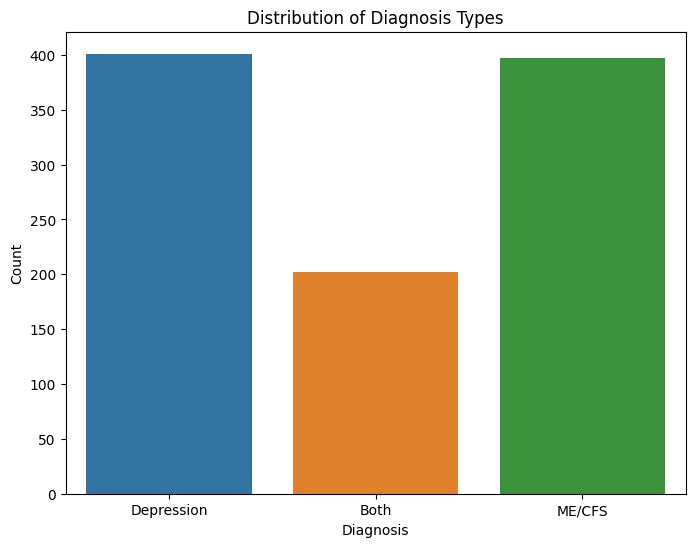

In [8]:
# Target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Diagnosis Types')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

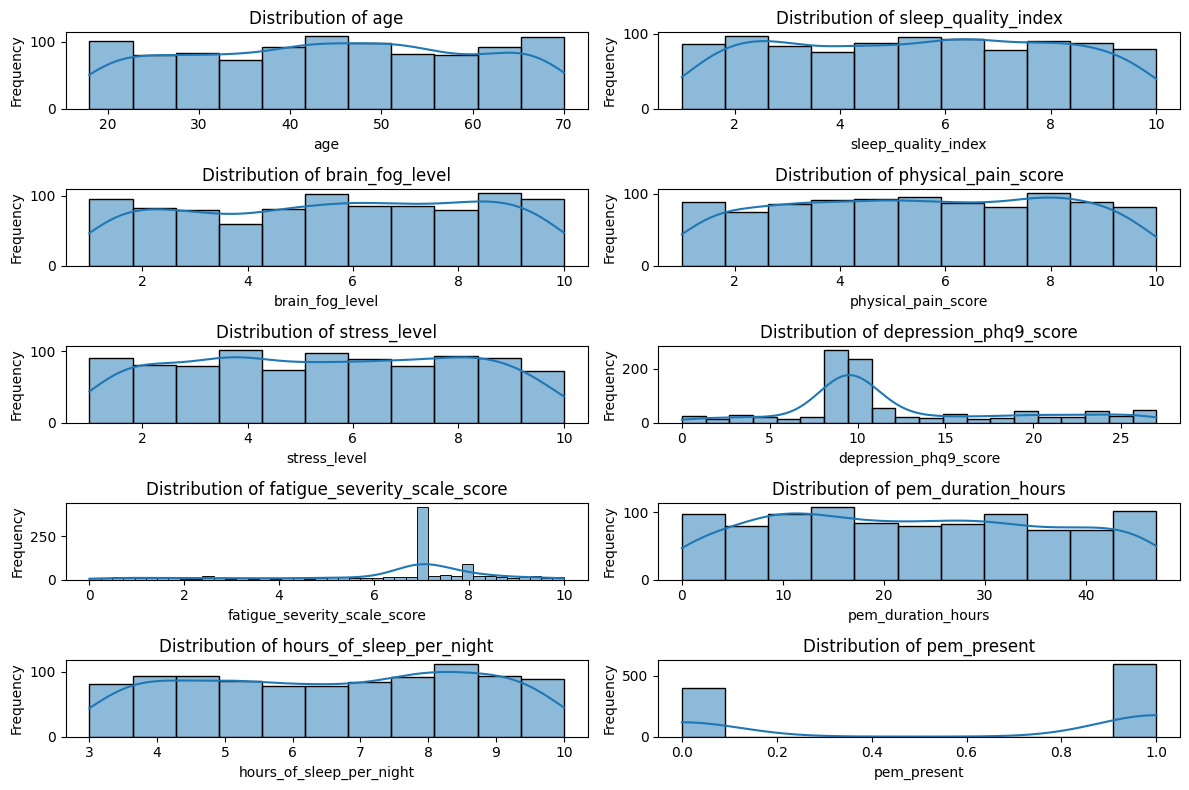

In [10]:
# Numerical feature distributions
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) + 1) // 2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

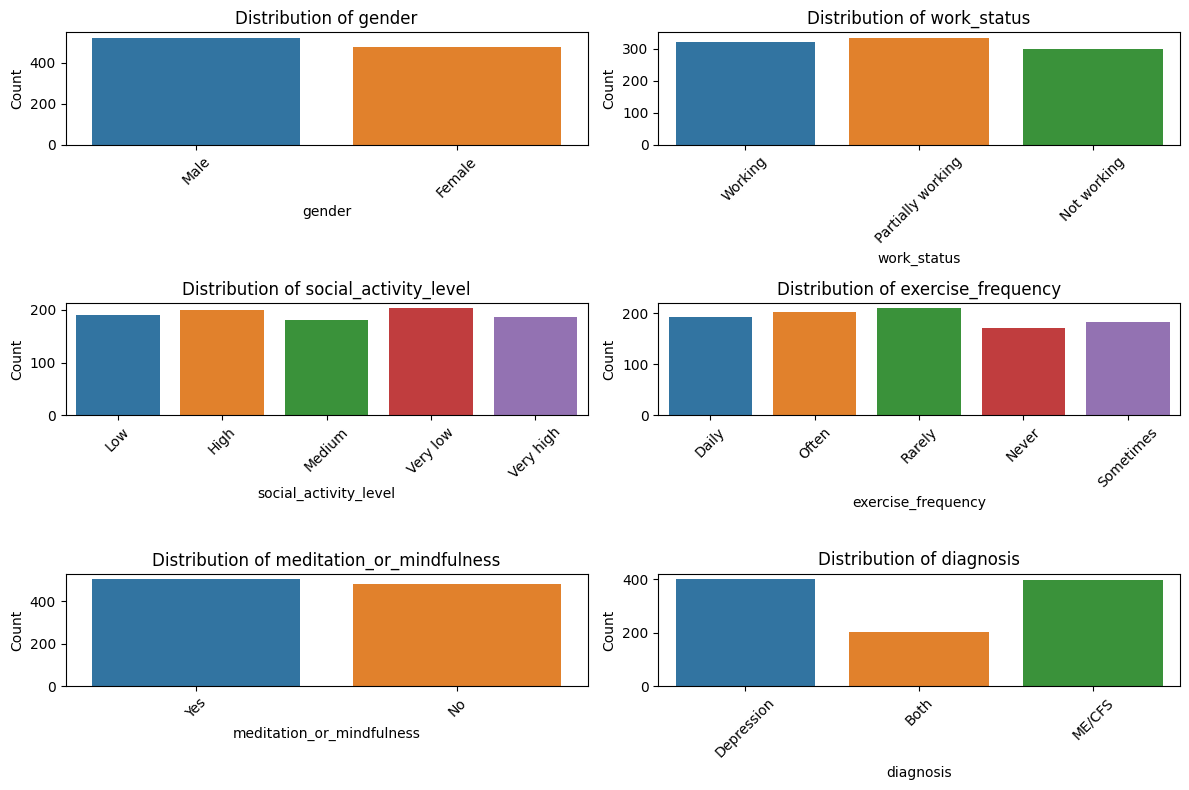

In [11]:
# Categorical feature distributions
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot((len(categorical_cols) + 1) // 2, 2, i)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

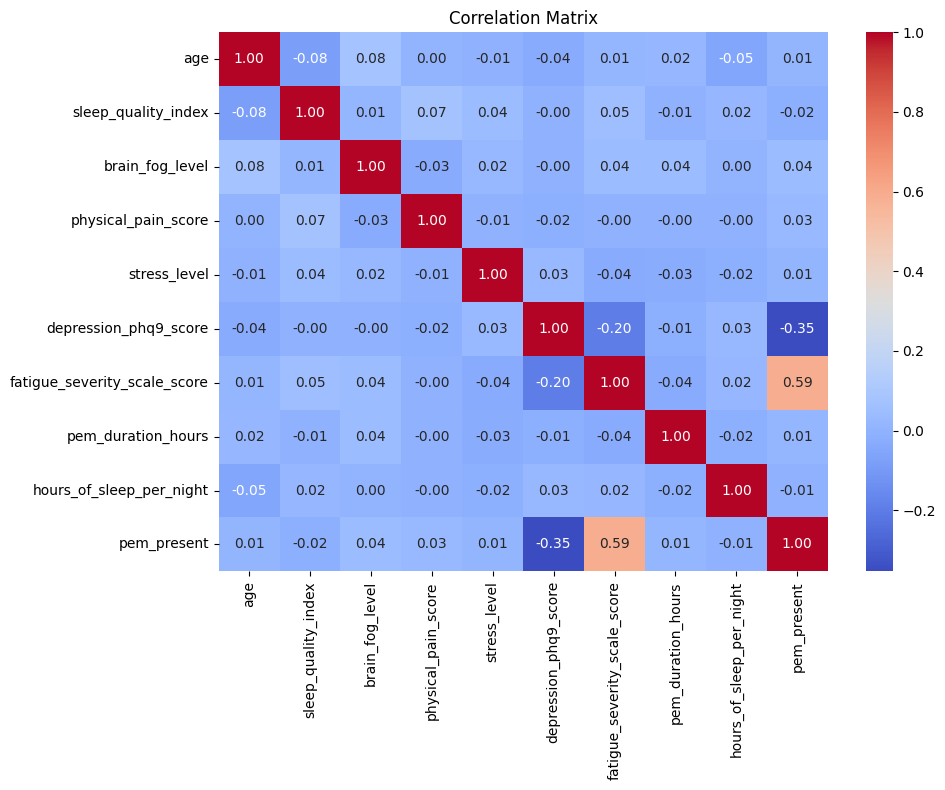

In [13]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

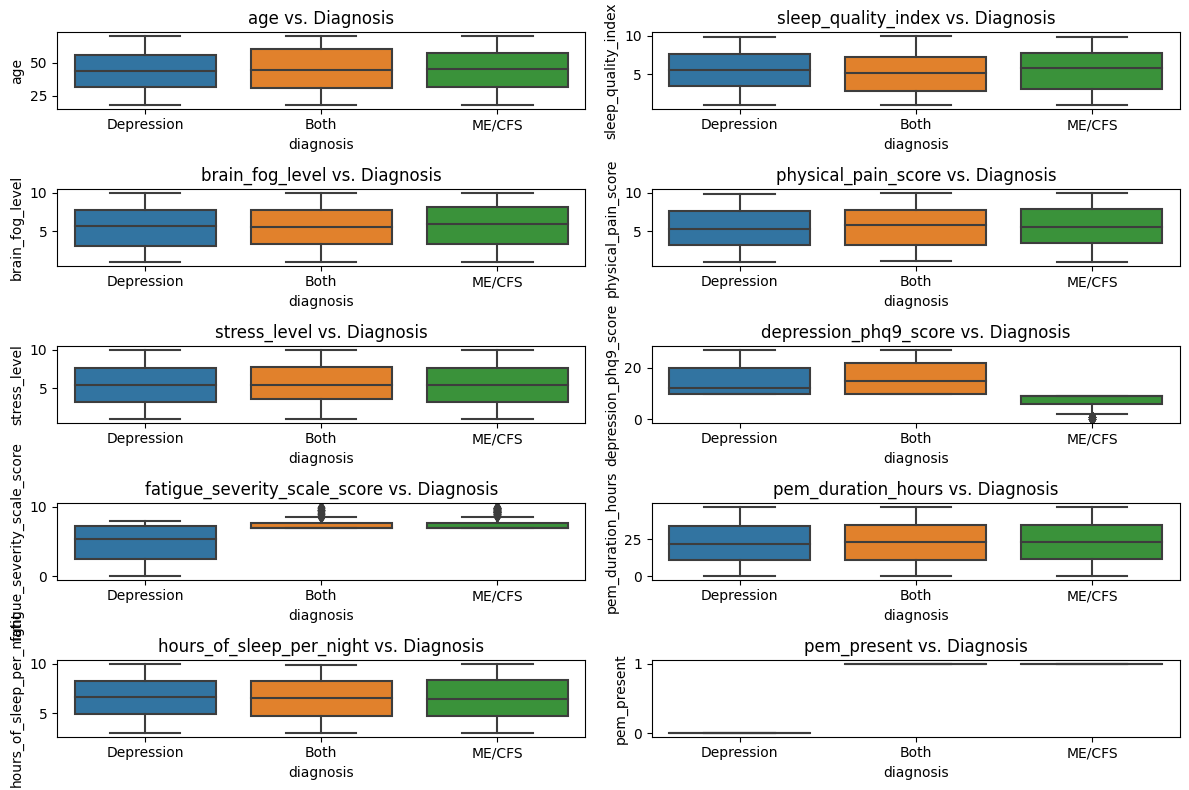

In [15]:
# Boxplots for numerical features vs. Diagnosis
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) + 1) // 2, 2, i)
    sns.boxplot(x='diagnosis', y=col, data=df)
    plt.title(f'{col} vs. Diagnosis')
plt.tight_layout()
plt.show()

#### **Analysis of Plots**

**1. Distribution of Diagnosis Types:**

- The target variable shows "Depression" and "ME/CFS" with similar counts, while "Both" has a lower count. This class imbalance may require handling during preprocessing (e.g., oversampling or class weighting).

**2. Numerical Feature Distributions:**

- Histograms show that most numerical features (e.g., age, sleep_quality_index, physical_pain_score) are roughly normally distributed, though fatigue_severity_scale_score and pem_duration_hours show skewness with peaks at higher values.
- pem_present is binary, and hours_of_sleep_per_night clusters around 6-7, which is typical for sleep data.

**3. Categorical Feature Distributions:**

- gender is nearly balanced (≈400 males, ≈600 females), while work_status shows "Working" (≈300), "Partially working" (≈200), and "Not working" (≈200).
- social_activity_level and exercise_frequency have multiple categories with varying distributions (e.g., "Low" and "Daily" are more frequent), and meditation_or_mindfulness is imbalanced (≈600 "Yes", ≈400 "No").

**4. Boxplots:**

- age shows similar medians across diagnoses, with "Both" slightly higher, a sign that age may not be a strong differentiator.
- sleep_quality_index, brain_fog_level, and physical_pain_score show overlapping interquartile ranges but potential differences in medians 
- depression_phq9_score and fatigue_severity_scale_score exhibit higher medians for "Both" and "ME/CFS" compared to "Depression," an indication that these may be key predictors.
- pem_duration_hours and hours_of_sleep_per_night show variability, with "ME/CFS" potentially having longer pem_duration_hours and lower sleep hours.

**5. Correlation Matrix:**

- Strong correlations exist within related features: fatigue_severity_scale_score and pem_duration_hours (0.59), depression_phq9_score and pem_present (0.35). This points to multicollinearity that may need addressing.
- Weak correlations with age indicate it may not be a primary driver of diagnosis.
- pem_present and hours_of_sleep_per_night show a moderate negative correlation (-0.35), which could be insightful for feature engineering.

## 3. Data Preprocessing

In [18]:
# Handle missing values
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Impute numerical columns with median
num_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# Impute categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

In [19]:
# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [20]:
# Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [21]:
# Split features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [22]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
# Create a copy of the training data for hyperparameter tuning
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

## 4. Feature Engineering

In [25]:
# Create new features
X_train['sleep_stress_interaction'] = X_train['sleep_quality_index'] * X_train['stress_level']
X_train['fatigue_pem_interaction'] = X_train['fatigue_severity_scale_score'] * X_train['pem_duration_hours']
X_train['depression_fatigue_ratio'] = X_train['depression_phq9_score'] / (X_train['fatigue_severity_scale_score'] + 1e-10)  # Avoid division by zero
X_train['pain_stress_sum'] = X_train['physical_pain_score'] + X_train['stress_level']

In [26]:
# Apply the same transformations to X_test
X_test['sleep_stress_interaction'] = X_test['sleep_quality_index'] * X_test['stress_level']
X_test['fatigue_pem_interaction'] = X_test['fatigue_severity_scale_score'] * X_test['pem_duration_hours']
X_test['depression_fatigue_ratio'] = X_test['depression_phq9_score'] / (X_test['fatigue_severity_scale_score'] + 1e-10)
X_test['pain_stress_sum'] = X_test['physical_pain_score'] + X_test['stress_level']

## 5. Model Selection

In [29]:
# Initialize models
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb_clf = XGBClassifier(random_state=42, scale_pos_weight=2)  # Adjust for imbalance

In [30]:
# Fit models
log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [31]:
# Predict on test set
y_pred_log_reg = log_reg.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

In [32]:
# Evaluate models
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.78        41
           1       1.00      0.97      0.99        80
           2       0.86      0.99      0.92        79

    accuracy                           0.92       200
   macro avg       0.92      0.88      0.89       200
weighted avg       0.92      0.92      0.92       200


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       1.00      1.00      1.00        80
           2       1.00      0.99      0.99        79

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1    

In [33]:
# Cross-validation scores
log_reg_cv = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1_weighted')
rf_cv = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='f1_weighted')
xgb_cv = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='f1_weighted')

In [34]:
# Print scores
print("\nCross-Validation F1 Scores (Weighted):")
print(f"Logistic Regression: {log_reg_cv.mean():.3f} (+/- {log_reg_cv.std() * 2:.3f})")
print(f"Random Forest: {rf_cv.mean():.3f} (+/- {rf_cv.std() * 2:.3f})")
print(f"XGBoost: {xgb_cv.mean():.3f} (+/- {xgb_cv.std() * 2:.3f})")


Cross-Validation F1 Scores (Weighted):
Logistic Regression: 0.962 (+/- 0.035)
Random Forest: 0.991 (+/- 0.010)
XGBoost: 0.988 (+/- 0.016)


- Both Random Forest and XGBoost outperform Logistic Regression, with near-perfect metrics, likely due to their ability to capture non-linear interactions from the engineered features.
- Random Forest shows better stability than XGBoost slightly, with a higher cross-validation F1 mean (0.991 vs. 0.988) and lower standard deviation (0.010 vs. 0.016).
- We will further tune Random Forest to see if we can improve results.

## 6. Hyperparameter Tuning

In [36]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', {0: 1, 1: 1, 2: 1.5}]  # Adjust for minority class
}

In [37]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

In [38]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_copy, y_train_copy)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 1, 2: 1.5}],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_weighted')

In [39]:
# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation F1 Score:", grid_search.best_score_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation F1 Score: 0.9913073725764077


In [40]:
# Train final model with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [41]:
# Predict on test set
y_pred_best_rf = best_rf.predict(X_test)

In [42]:
# Evaluate final model
print("\nTuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))


Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       1.00      1.00      1.00        80
           2       1.00      0.99      0.99        79

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



## 7. Model Evaluation and Interpretation

In [44]:
# Evaluate on test set
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)

In [45]:
# Classification report
print("Final Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

Final Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       1.00      1.00      1.00        80
           2       1.00      0.99      0.99        79

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200



In [46]:
# ROC-AUC score (one-vs-rest)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"\nROC-AUC Score (One-vs-Rest): {roc_auc:.3f}")


ROC-AUC Score (One-vs-Rest): 0.999


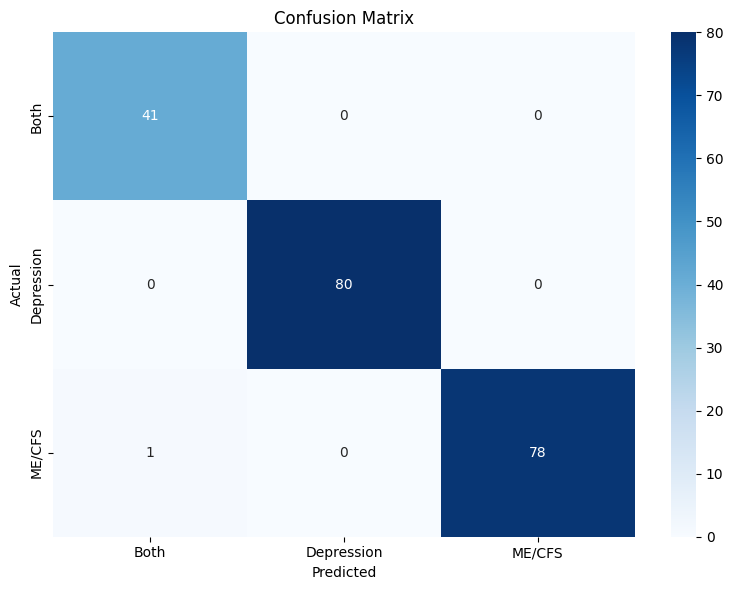

In [47]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoders['diagnosis'].classes_, yticklabels=label_encoders['diagnosis'].classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

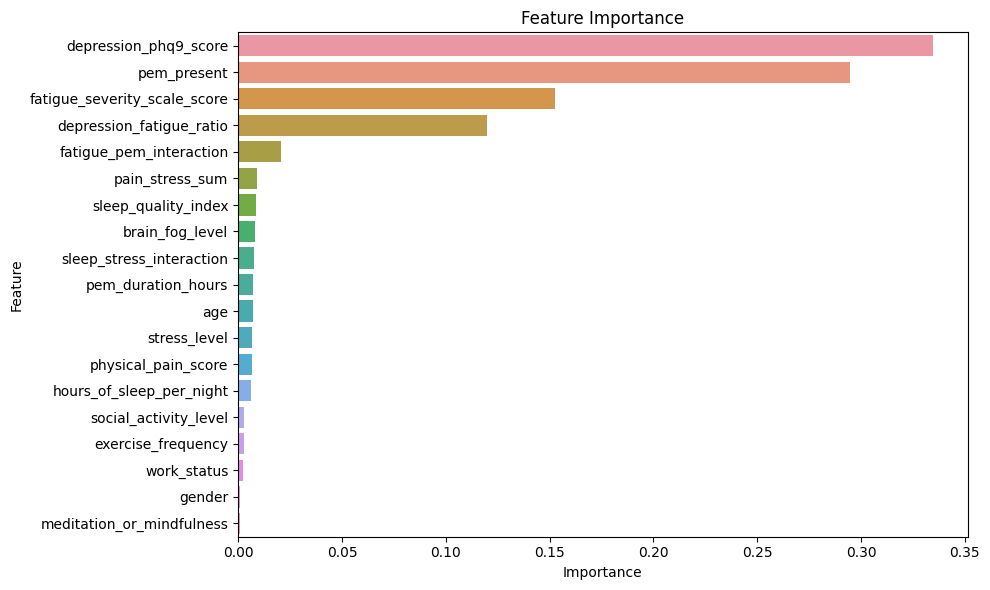

In [48]:
# Feature importance
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': best_rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()